# `eo-grow` Tutorial

The main objects in `eo-grow` package are structured like this

![eo-grow flowchart](./eo-grow.png)

Let's take a close look in each of them

## Config

Object in charge of storing and loading configuration parameters. It inherits from `munch.Munch` class.

It can be initialized either with a dictionary or a file path to a json file

In [1]:
from eogrow.core.config import Config

example_config_dict = {"foo_param": "foo_value"}

config = Config.from_dict(example_config_dict)

config

Config({
 'foo_param': 'foo_value'
})

There are 2 ways of accessing values from config object

In [2]:
print(config.foo_param)
print(config["foo_param"])

foo_value
foo_value


`Config` can load configuration from a json file

In [3]:
import os

CONFIG_FOLDER = os.path.join("..", "tests", "test_config_files")
CONFIG_FILE = os.path.join(CONFIG_FOLDER, "simple_config.json")

config = Config.from_path(CONFIG_FILE)

for key, value in config.items():
    print(f"{key}: {value}")

pipeline: SimplePipeline
test_param: 10
patch_list: [0, 1]
workers: 3
logging: Config({
 'capture_warnings': True,
 'manager': 'eogrow.core.logging.LoggingManager',
 'save_logs': True,
 'show_logs': True
})
area: Config({
 'area_buffer': 0.001,
 'area_filename': 'test_area.geojson',
 'manager': 'eogrow.core.area.UtmZoneAreaManager',
 'offset_x': 0,
 'offset_y': 0,
 'patch_buffer': 0.1,
 'patch_size_x': 2400,
 'patch_size_y': 1100
})
eopatch: Config({
 'manager': 'eogrow.core.eopatch.EOPatchManager'
})
storage: Config({
 'manager': 'eogrow.core.storage.StorageManager',
 'project_folder': '/home/ubuntu/Sinergise/eo-grow/tests/test_project',
 'structure': {'data': 'data',
               'data_2019': 'data-2019',
               'data_custom_range': 'data-custom-range',
               'data_sampled': 'data-sampled',
               'features': 'features',
               'features_sampled': 'features-sampled',
               'maps': 'maps',
               'models': 'models',
               'p

## StorageManager

Object in charge of folder structure of data. It contains a definition of entire folder structure

In [4]:
from eogrow.core.storage import StorageManager

storage = StorageManager(config.storage)

storage

The following folders are always defined in the folder structure

In [5]:
print(storage.get_input_data_folder())
print(storage.get_cache_folder())
print(storage.get_logs_folder())

input-data
cache
logs


Any other folder is custom defined

In [6]:
storage.get_folder("data", full_path=True)

'/home/ubuntu/Sinergise/eo-grow/tests/test_project/data'

## AreaManager

The object in charge of splitting and managing area of interest (AOI)

In [7]:
from eogrow.core.area import UtmZoneAreaManager

area_manager = UtmZoneAreaManager(config.area, storage)

area_manager.get_area_dataframe()

,Regions,geometry
0,Region A,"POLYGON ((47.68344 39.64700, 47.68920 39.63618..."
1,Region B,"POLYGON ((47.68132 39.64580, 47.69457 39.64752..."
2,Region C,"POLYGON ((47.68563 39.64197, 47.69217 39.63793..."


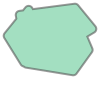

In [8]:
geometry = area_manager.get_area_geometry()

geometry.geometry

In [9]:
area_manager.get_grid()[0]

,index_n,index_x,index_y,geometry
0,0,0,0,"POLYGON ((729480.000 4390045.000, 729480.000 4..."
1,1,0,1,"POLYGON ((729480.000 4391145.000, 729480.000 4..."


## EOPatchManager

The object used to manage `EOPatch` naming

In [10]:
from eogrow.core.eopatch import EOPatchManager

eopatch_manager = EOPatchManager(config.eopatch, area_manager)

eopatch_manager.get_eopatch_filenames()

['eopatch-id-0-col-0-row-0', 'eopatch-id-1-col-0-row-1']

In [11]:
eopatches = eopatch_manager.get_eopatch_filenames()

eopatch_manager.save_eopatch_filenames("test.json", eopatches)

In [12]:
loaded_eopatches = eopatch_manager.load_eopatch_filenames("test.json")

len(loaded_eopatches)

2

In [13]:
loaded_eopatches

['eopatch-id-0-col-0-row-0', 'eopatch-id-1-col-0-row-1']

In [14]:
eopatch_manager.is_eopatch_name("something"), eopatch_manager.is_eopatch_name("eopatch-id-0-col-0-row-0")

(False, True)

## Pipeline

The main object in the package is `Pipeline`. It contains a schema for config parameters and a data-processing procedure.

In [15]:
from pydantic import Field

from eogrow.core.pipeline import Pipeline
from eogrow.core.schemas import PipelineSchema


class SimplePipeline(Pipeline):
    class Schema(Pipeline.Schema):
        test_param: int = Field(..., description="Some integer")

    def run_procedure(self):
        # implement something and return which EOPatches have been successfully processed and which not

        return [], []


pipeline = SimplePipeline(config)

pipeline.run()

INFO eogrow.core.pipeline:216: Running SimplePipeline
INFO eogrow.core.pipeline:230: Pipeline finished successfully!
INFO eogrow.core.area.base:176: Loading grid from cache/grid_test_area_UtmZoneAreaManager_0.001__2400_1100_0.1_0.0_0.0.gpkg
